In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset,DataLoader

In [2]:
df = pd.read_csv(r"C:\Users\admin\Desktop\week_of_data4_headFlaw.csv",encoding='utf-8',header=None)
df.head(10)

,0,1,2,3
0,2015/5/20 0:00,263,240,2015/5/20
1,2015/5/20 0:05,263,234,2015/5/20
2,2015/5/20 0:10,263,228,2015/5/20
3,2015/5/20 0:15,263,227,2015/5/20
4,2015/5/20 0:20,263,228,2015/5/20
5,2015/5/20 0:25,263,226,2015/5/20
6,2015/5/20 0:30,263,224,2015/5/20
7,2015/5/20 0:35,263,219,2015/5/20
8,2015/5/20 0:40,263,213,2015/5/20
9,2015/5/20 0:45,263,205,2015/5/20


In [3]:
df.columns = ['time','id','gl', 'date']
df = df[['time','id','gl']]
df.head()

,time,id,gl
0,2015/5/20 0:00,263,240
1,2015/5/20 0:05,263,234
2,2015/5/20 0:10,263,228
3,2015/5/20 0:15,263,227
4,2015/5/20 0:20,263,228


In [4]:
ID = df['id'].value_counts().index
pd.set_option('display.max_rows',100)
print(ID)
print(len(ID))

Index([263, 106, 185, 218,  74,  53, 216, 219, 113,  47,  14, 134,  37,  61,
        46,  33,  54, 278, 136, 274,   9, 265, 283, 273, 119, 129,  32,  27,
       236,  26, 206,  18, 165,  31,  24, 267,  22, 247, 124,  79, 258,  58,
       234, 175, 156, 158, 188, 189, 201, 203,  77, 127,  67,  70, 102, 137,
         7,  95, 232,  23, 271, 130,  68, 227, 228, 164, 111, 251, 155, 245,
       229, 277, 193, 101, 269,   3, 250, 116, 109,  81,  65, 184, 146, 105,
       138,  76, 198, 139, 214, 166, 135, 123, 253, 187,  17, 205, 220, 243,
       281],
      dtype='int64', name='id')
99


In [5]:
#获取数据

# 创建空的DataFrame
total_data = {'id': [],'month':[],'day':[],'hour':[],'minute':[],'weekday':[],'gl': []}
total_data = pd.DataFrame(total_data)

for i in ID:
    print("开始获取id为{}的被试数据：---------------------------------".format(i))
    data = df[df['id']== i].copy() 
    print(data.shape)
    #将time列设成date数据类型
    data['time'] = pd.to_datetime(data['time'])

    #按照时间排序
    data = data.sort_values(by='time') 

    #提取月为单独的一列
    data['month'] = data['time'].dt.month

    #提取日为单独的一列
    data['day'] = data['time'].dt.day

    #提取小时为单独的一列
    data['hour'] = data['time'].dt.hour

    #提取分钟为单独的一列
    data['minute'] = data['time'].dt.minute

    # 提取周几（0表示星期一，1表示星期二，依此类推）
    data['weekday'] = data['time'].dt.dayofweek

    data = data.set_index('time')

#     data['target'] = data['gl'].shift(-1)

    #使用了shift函数，在最后必然是有缺失值的，这里去掉缺失值所在行
    data = data.dropna()     

    data = data.astype(np.float32) # 修改数据类型
    
    #整合全部数据
    total_data = pd.concat([total_data, data], ignore_index=True)
    break

开始获取id为263的被试数据：---------------------------------
(2016, 3)


In [6]:
total_data

,id,month,day,hour,minute,weekday,gl
0,263.0,5.0,20.0,0.0,0.0,2.0,240.0
1,263.0,5.0,20.0,0.0,5.0,2.0,234.0
2,263.0,5.0,20.0,0.0,10.0,2.0,228.0
3,263.0,5.0,20.0,0.0,15.0,2.0,227.0
4,263.0,5.0,20.0,0.0,20.0,2.0,228.0
...,...,...,...,...,...,...,...
2011,263.0,5.0,26.0,23.0,38.0,1.0,152.0
2012,263.0,5.0,26.0,23.0,43.0,1.0,160.0
2013,263.0,5.0,26.0,23.0,48.0,1.0,166.0
2014,263.0,5.0,26.0,23.0,53.0,1.0,173.0


In [7]:
#窗口划分
# 创建一个空的三维数组
seq = 24
train_total_feats = np.empty((0, seq, 7))
train_total_targets = np.empty((0,7))

validation_set_feats = np.empty((0, seq, 7))
validation_set_targets = np.empty((0, 7))

test_total_feats = np.empty((0, seq, 7))
test_total_targets = np.empty((0, 7))

# 设每条数据序列有48组数据

for i in ID:
    data = total_data[total_data['id'] == i]
    print("当前被试(id == {})的数据集长度：".format(i),data.shape)
    
    # 创建两个列表，用来存储当前被试的数据特征和标签
    one_feats = np.empty((0, seq, 7))
    one_targets = np.empty((0,7))
    for index in range(len(data) - seq):
        # 构建特征集
        one_feats = np.concatenate((one_feats, data[index: index + seq].values.reshape(-1,seq,7)), axis=0)
        # 构建target集
        one_targets = np.concatenate((one_targets, data.iloc[index + seq].values.reshape(1,-1)), axis=0)
        
    #划分每个被试的训练集和测试集
    test_size = int(np.round(0.03 * one_feats.shape[0]))  
    
    validation_size = int(np.round(0.2 * one_feats.shape[0]))  
    
    train_size = one_feats.shape[0] - test_size - validation_size 
    
    train_total_feats = np.concatenate((train_total_feats, one_feats[:train_size, :, :]), axis=0)
    train_total_targets = np.concatenate((train_total_targets, one_targets[:train_size,:]), axis=0)
    
    validation_set_feats = np.concatenate((validation_set_feats, one_feats[train_size:train_size+validation_size, :, :]), axis=0)
    validation_set_targets = np.concatenate((validation_set_targets, one_targets[train_size:train_size+validation_size, :]), axis=0)
    
    test_total_feats = np.concatenate((test_total_feats, one_feats[-test_size:, :, :]), axis=0)
    test_total_targets = np.concatenate((test_total_targets, one_targets[-test_size:, :]), axis=0)
    break

当前被试(id == 263)的数据集长度： (2016, 7)


In [8]:
# 将变量保存到文件，以便下次直接读取，不用在处理数据
np.save('./variable_file/train_total_feats_1.npy',train_total_feats)
np.save('./variable_file/train_total_targets_1.npy',train_total_targets)

np.save('./variable_file/validation_set_feats_1.npy',validation_set_feats)
np.save('./variable_file/validation_set_targets_1.npy',validation_set_targets)

np.save('./variable_file/test_total_feats_1.npy',test_total_feats)
np.save('./variable_file/test_total_targets_1.npy',test_total_targets)

In [9]:
# 加载变量的代码：train_total_feats = np.load('./variable_file/train_total_feats_1.npy')
train_total_feats = np.load('./variable_file/train_total_feats_1.npy')
train_total_targets = np.load('./variable_file/train_total_targets_1.npy')

validation_set_feats = np.load('./variable_file/validation_set_feats_1.npy')
validation_set_targets = np.load('./variable_file/validation_set_targets_1.npy')

test_total_feats = np.load('./variable_file/test_total_feats_1.npy')
test_total_targets = np.load('./variable_file/test_total_targets_1.npy')

print("训练数据窗口总数：",train_total_feats.shape)
print("训练数据标签总数：",train_total_targets.shape)

print("验证数据窗口总数：",validation_set_feats.shape)
print("验证数据标签总数：",validation_set_targets.shape)

print("测试数据窗口数：",test_total_feats.shape)
print("测试数据标签数：",test_total_targets.shape)

训练数据窗口总数： (1534, 24, 7)
训练数据标签总数： (1534, 7)
验证数据窗口总数： (398, 24, 7)
验证数据标签总数： (398, 7)
测试数据窗口数： (60, 24, 7)
测试数据标签数： (60, 7)


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(-1, 1))  
scaler_train_total_feats = scaler1.fit_transform(train_total_feats.reshape(-1,7))
scaler_train_total_targets = scaler1.transform(train_total_targets)

scaler2 = MinMaxScaler(feature_range=(-1, 1))
scaler_validation_set_feats = scaler2.fit_transform(validation_set_feats.reshape(-1,7))
scaler_validation_set_targets = scaler2.transform(validation_set_targets)

scaler3 = MinMaxScaler(feature_range=(-1, 1))
scaler_test_total_feats = scaler3.fit_transform(test_total_feats.reshape(-1,7))
scaler_test_total_targets = scaler3.transform(test_total_targets)

In [12]:
#将三维NumPy数组变成二维、进行归一化、反归一化、然后再将其变回三维的过程中，最终的数据可能不会与最初的数据完全一样。
#这是因为归一化和反归一化过程中可能会引入数值精度的损失，导致微小的数值差异。(最重要的是数据排列不变)
Raw_train_total_feats = scaler1.inverse_transform(scaler_train_total_feats).reshape(-1,24,7)
np.allclose(train_total_feats, Raw_train_total_feats)

True

In [22]:
device =  torch.device("cuda:0")
trainX = torch.from_numpy(scaler_train_total_feats.reshape(-1,seq,7)).type(torch.Tensor).to(device)
trainY = torch.from_numpy(scaler_train_total_targets).type(torch.Tensor).to(device)

validationX = torch.from_numpy(scaler_validation_set_feats.reshape(-1,seq,7)).type(torch.Tensor).to(device)
validationY = torch.from_numpy(scaler_validation_set_targets).type(torch.Tensor).to(device)

testX = torch.from_numpy(scaler_test_total_feats.reshape(-1,seq,7)).type(torch.Tensor).to(device)
testY = torch.from_numpy(scaler_test_total_targets).type(torch.Tensor).to(device)

In [14]:
print('x_train.shape = ',trainX.shape)
print('y_train.shape = ',trainY.shape)
print('x_test.shape = ',validationX.shape)
print('y_test.shape = ',validationY.shape)

x_train.shape =  torch.Size([1534, 24, 7])
y_train.shape =  torch.Size([1534, 7])
x_test.shape =  torch.Size([398, 24, 7])
y_test.shape =  torch.Size([398, 7])


In [15]:
batch_size= 32
train = TensorDataset(trainX,trainY)
validation = TensorDataset(validationX,validationY)

train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=validation, batch_size=batch_size, shuffle=False)

In [16]:
import torch.nn as nn

input_dim = 7      # 数据的特征数
hidden_dim = 64   # LSTM1隐藏层的神经元个数
num_layers = 2     # LSTM的层数
output_dim = 7     # 预测值的特征数

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_dim = input_dim
        
        self.output_dim = output_dim
        
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
    
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)   
        
    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).cuda()
        
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).cuda()
        
        out, (h0_1, c0_1) = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:,-1,:]) 

        return out

In [17]:
# 实例化模型
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model = model.to(device)

# 定义优化器和损失函数
optimiser = torch.optim.Adam(model.parameters(), lr=0.001) # 使用Adam优化算法
loss_fn = torch.nn.MSELoss(reduction='mean')             # 使用均方差作为损失函数
loss_fn = loss_fn.to(device)

# 设定数据遍历次数
num_epochs = 300

# 打印模型结构
print(model)

LSTM(
  (lstm): LSTM(7, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=7, bias=True)
)


In [18]:
# train model

# 记录训练次数
total_train_step = 0
# 记录测试次数
total_test_step = 0    


for t in range(num_epochs):
    print("--------------------第{}轮训练开始----------------------".format(t+1))
    model.train()
    
    # 记录一轮训练的总损失值
    total_train_loss = 0
    for data in train_loader:
        feats, tars = data
        feats = feats
        tars = tars
        
        y_train_pred = model(feats)
        
        
        loss = loss_fn(y_train_pred, tars)
        
        total_train_loss += loss
        
        optimiser.zero_grad()

        loss.backward()

        optimiser.step()

        total_train_step += 1
        
        if total_train_step % 5 == 0:
            print("训练次数：{}, Loss: {}".format(total_train_step,loss.item()))
    print('第 {} 轮训练总体误差值：{}'.format(t+1,total_train_loss))
    
    #测试步骤开始
    total_test_loss = 0
    total_accuracy = 0
    
    model.eval()
    with torch.no_grad():
        print("**********开始本轮验证**********".format(t+1))
        for data in test_loader:
            feats,tars = data
            feats = feats
            tars = tars

            y_train_pred = model(feats)
            
            loss = loss_fn(y_train_pred,tars)
            
            total_test_loss += loss.item()
            
    print("第 {} 轮训练在整体验证集上的Loss: {}".format(t+1,total_test_loss))

    total_test_step += 1

    #保存每一轮训练的模型
    torch.save(model.state_dict(), "./saved_model3/allen_{}.pth".format(t))
    print("allen_{}.pth 模型已保存".format(t))

--------------------第1轮训练开始----------------------
训练次数：5, Loss: 0.536666989326477
训练次数：10, Loss: 0.43250811100006104
训练次数：15, Loss: 0.21603745222091675
训练次数：20, Loss: 0.21882207691669464
训练次数：25, Loss: 0.20482079684734344
训练次数：30, Loss: 0.12428870797157288
训练次数：35, Loss: 0.19429627060890198
训练次数：40, Loss: 0.12291869521141052
训练次数：45, Loss: 0.7191054224967957
第 1 轮训练总体误差值：15.428574562072754
**********开始本轮验证**********
第 1 轮训练在整体验证集上的Loss: 6.764100827276707
allen_0.pth 模型已保存
--------------------第2轮训练开始----------------------
训练次数：50, Loss: 0.72048020362854
训练次数：55, Loss: 0.5057145357131958
训练次数：60, Loss: 0.2092481553554535
训练次数：65, Loss: 0.2606348693370819
训练次数：70, Loss: 0.09261009097099304
训练次数：75, Loss: 0.27190709114074707
训练次数：80, Loss: 0.15641765296459198
训练次数：85, Loss: 0.3151453733444214
训练次数：90, Loss: 0.2050294578075409
训练次数：95, Loss: 0.5451912879943848
第 2 轮训练总体误差值：14.641502380371094
**********开始本轮验证**********
第 2 轮训练在整体验证集上的Loss: 5.148224115371704
allen_1.pth 模型已保存
----------------

训练次数：815, Loss: 0.011733049526810646
第 17 轮训练总体误差值：0.8505866527557373
**********开始本轮验证**********
第 17 轮训练在整体验证集上的Loss: 0.7912035509943962
allen_16.pth 模型已保存
--------------------第18轮训练开始----------------------
训练次数：820, Loss: 0.018170058727264404
训练次数：825, Loss: 0.037267766892910004
训练次数：830, Loss: 0.01200341247022152
训练次数：835, Loss: 0.006323696114122868
训练次数：840, Loss: 0.007182691246271133
训练次数：845, Loss: 0.004819205030798912
训练次数：850, Loss: 0.010589214973151684
训练次数：855, Loss: 0.005888150539249182
训练次数：860, Loss: 0.006298688240349293
第 18 轮训练总体误差值：0.7295918464660645
**********开始本轮验证**********
第 18 轮训练在整体验证集上的Loss: 0.41877258382737637
allen_17.pth 模型已保存
--------------------第19轮训练开始----------------------
训练次数：865, Loss: 0.021432969719171524
训练次数：870, Loss: 0.008974054828286171
训练次数：875, Loss: 0.008403602056205273
训练次数：880, Loss: 0.010612580925226212
训练次数：885, Loss: 0.00720725255087018
训练次数：890, Loss: 0.009883301332592964
训练次数：895, Loss: 0.009347504004836082
训练次数：900, Loss: 0.031835824251

训练次数：1630, Loss: 0.01704287901520729
第 34 轮训练总体误差值：0.36942440271377563
**********开始本轮验证**********
第 34 轮训练在整体验证集上的Loss: 0.7179521396756172
allen_33.pth 模型已保存
--------------------第35轮训练开始----------------------
训练次数：1635, Loss: 0.009416243992745876
训练次数：1640, Loss: 0.00815724115818739
训练次数：1645, Loss: 0.004334221128374338
训练次数：1650, Loss: 0.03329191729426384
训练次数：1655, Loss: 0.0017118289833888412
训练次数：1660, Loss: 0.004519856534898281
训练次数：1665, Loss: 0.0034434909466654062
训练次数：1670, Loss: 0.0021668679546564817
训练次数：1675, Loss: 0.003886591177433729
训练次数：1680, Loss: 0.012974673882126808
第 35 轮训练总体误差值：0.42959079146385193
**********开始本轮验证**********
第 35 轮训练在整体验证集上的Loss: 0.6212702328339219
allen_34.pth 模型已保存
--------------------第36轮训练开始----------------------
训练次数：1685, Loss: 0.0059461393393576145
训练次数：1690, Loss: 0.003467558417469263
训练次数：1695, Loss: 0.009764107875525951
训练次数：1700, Loss: 0.0017703692428767681
训练次数：1705, Loss: 0.006958042737096548
训练次数：1710, Loss: 0.004087628796696663
训练次数：171

训练次数：2445, Loss: 0.017357684671878815
第 51 轮训练总体误差值：0.35819756984710693
**********开始本轮验证**********
第 51 轮训练在整体验证集上的Loss: 0.42428915575146675
allen_50.pth 模型已保存
--------------------第52轮训练开始----------------------
训练次数：2450, Loss: 0.009153202176094055
训练次数：2455, Loss: 0.0029741949401795864
训练次数：2460, Loss: 0.008088314905762672
训练次数：2465, Loss: 0.0024775643832981586
训练次数：2470, Loss: 0.0014346876414492726
训练次数：2475, Loss: 0.01210634782910347
训练次数：2480, Loss: 0.002701160265132785
训练次数：2485, Loss: 0.0009757201187312603
训练次数：2490, Loss: 0.001629295409657061
训练次数：2495, Loss: 0.004117803182452917
第 52 轮训练总体误差值：0.21581166982650757
**********开始本轮验证**********
第 52 轮训练在整体验证集上的Loss: 0.39389007072895765
allen_51.pth 模型已保存
--------------------第53轮训练开始----------------------
训练次数：2500, Loss: 0.007336627691984177
训练次数：2505, Loss: 0.01083285640925169
训练次数：2510, Loss: 0.009064970538020134
训练次数：2515, Loss: 0.0016372615937143564
训练次数：2520, Loss: 0.0036112891975790262
训练次数：2525, Loss: 0.001415278296917677
训练次数

训练次数：3260, Loss: 0.0025146391708403826
第 68 轮训练总体误差值：0.36054128408432007
**********开始本轮验证**********
第 68 轮训练在整体验证集上的Loss: 0.7986378027126193
allen_67.pth 模型已保存
--------------------第69轮训练开始----------------------
训练次数：3265, Loss: 0.11523184180259705
训练次数：3270, Loss: 0.02864886447787285
训练次数：3275, Loss: 0.008795887231826782
训练次数：3280, Loss: 0.01885298639535904
训练次数：3285, Loss: 0.005895686335861683
训练次数：3290, Loss: 0.012776101008057594
训练次数：3295, Loss: 0.003539038123562932
训练次数：3300, Loss: 0.016305185854434967
训练次数：3305, Loss: 0.001257976284250617
训练次数：3310, Loss: 0.020439838990569115
第 69 轮训练总体误差值：0.8694055676460266
**********开始本轮验证**********
第 69 轮训练在整体验证集上的Loss: 0.7230254467576742
allen_68.pth 模型已保存
--------------------第70轮训练开始----------------------
训练次数：3315, Loss: 0.028424404561519623
训练次数：3320, Loss: 0.007783888839185238
训练次数：3325, Loss: 0.008790052495896816
训练次数：3330, Loss: 0.01397008914500475
训练次数：3335, Loss: 0.0016889511607587337
训练次数：3340, Loss: 0.0054291351698338985
训练次数：3345, L

训练次数：4060, Loss: 0.005314281675964594
训练次数：4065, Loss: 0.001182241947390139
训练次数：4070, Loss: 0.0022820187732577324
训练次数：4075, Loss: 0.0014093799982219934
训练次数：4080, Loss: 0.007450908422470093
第 85 轮训练总体误差值：0.33131080865859985
**********开始本轮验证**********
第 85 轮训练在整体验证集上的Loss: 0.6024649599567056
allen_84.pth 模型已保存
--------------------第86轮训练开始----------------------
训练次数：4085, Loss: 0.029990950599312782
训练次数：4090, Loss: 0.007342991419136524
训练次数：4095, Loss: 0.009051202796399593
训练次数：4100, Loss: 0.002865221817046404
训练次数：4105, Loss: 0.006255688611418009
训练次数：4110, Loss: 0.0042865341529250145
训练次数：4115, Loss: 0.007518733385950327
训练次数：4120, Loss: 0.0023308272939175367
训练次数：4125, Loss: 0.024582048878073692
第 86 轮训练总体误差值：0.5932316184043884
**********开始本轮验证**********
第 86 轮训练在整体验证集上的Loss: 0.5964307030662894
allen_85.pth 模型已保存
--------------------第87轮训练开始----------------------
训练次数：4130, Loss: 0.010824655182659626
训练次数：4135, Loss: 0.004989244043827057
训练次数：4140, Loss: 0.005265611689537764
训练次数：41

训练次数：4860, Loss: 0.011517150327563286
训练次数：4865, Loss: 0.011490043252706528
训练次数：4870, Loss: 0.010519307106733322
训练次数：4875, Loss: 0.015479523688554764
训练次数：4880, Loss: 0.010453692637383938
训练次数：4885, Loss: 0.0033887983299791813
训练次数：4890, Loss: 0.002622895175591111
训练次数：4895, Loss: 0.022815342992544174
第 102 轮训练总体误差值：0.9568528532981873
**********开始本轮验证**********
第 102 轮训练在整体验证集上的Loss: 0.8252496421337128
allen_101.pth 模型已保存
--------------------第103轮训练开始----------------------
训练次数：4900, Loss: 0.006176070775836706
训练次数：4905, Loss: 0.02415871061384678
训练次数：4910, Loss: 0.0036729557905346155
训练次数：4915, Loss: 0.002174102934077382
训练次数：4920, Loss: 0.0011506970040500164
训练次数：4925, Loss: 0.0012170582776889205
训练次数：4930, Loss: 0.0031839802395552397
训练次数：4935, Loss: 0.0007601940887980163
训练次数：4940, Loss: 0.0020326822996139526
第 103 轮训练总体误差值：0.43598848581314087
**********开始本轮验证**********
第 103 轮训练在整体验证集上的Loss: 0.7145312633365393
allen_102.pth 模型已保存
--------------------第104轮训练开始--------------------

训练次数：5655, Loss: 0.0004113382310606539
训练次数：5660, Loss: 0.0005278292810544372
第 118 轮训练总体误差值：0.09260014444589615
**********开始本轮验证**********
第 118 轮训练在整体验证集上的Loss: 0.3361901054158807
allen_117.pth 模型已保存
--------------------第119轮训练开始----------------------
训练次数：5665, Loss: 0.004139992408454418
训练次数：5670, Loss: 0.0006298942025750875
训练次数：5675, Loss: 0.0007220433908514678
训练次数：5680, Loss: 0.0008303978247568011
训练次数：5685, Loss: 0.0006557359010912478
训练次数：5690, Loss: 0.0026453877799212933
训练次数：5695, Loss: 0.0010076737962663174
训练次数：5700, Loss: 0.0040172310546040535
训练次数：5705, Loss: 0.0003052164101973176
训练次数：5710, Loss: 0.008067004382610321
第 119 轮训练总体误差值：0.08636433631181717
**********开始本轮验证**********
第 119 轮训练在整体验证集上的Loss: 0.35487344581633806
allen_118.pth 模型已保存
--------------------第120轮训练开始----------------------
训练次数：5715, Loss: 0.0032271461095660925
训练次数：5720, Loss: 0.011497911997139454
训练次数：5725, Loss: 0.0013771747471764684
训练次数：5730, Loss: 0.00440530339255929
训练次数：5735, Loss: 0.000622211

训练次数：6450, Loss: 0.008253728970885277
训练次数：6455, Loss: 0.001283559249714017
训练次数：6460, Loss: 0.0011013478506356478
训练次数：6465, Loss: 0.0020084045827388763
训练次数：6470, Loss: 0.0003492274263408035
训练次数：6475, Loss: 0.0012211110442876816
训练次数：6480, Loss: 0.011427842080593109
第 135 轮训练总体误差值：0.30370402336120605
**********开始本轮验证**********
第 135 轮训练在整体验证集上的Loss: 0.42618854250758886
allen_134.pth 模型已保存
--------------------第136轮训练开始----------------------
训练次数：6485, Loss: 0.002958348486572504
训练次数：6490, Loss: 0.0004082469968125224
训练次数：6495, Loss: 0.0022651911713182926
训练次数：6500, Loss: 0.0010357638821005821
训练次数：6505, Loss: 0.002541925059631467
训练次数：6510, Loss: 0.0015119814779609442
训练次数：6515, Loss: 0.004770373925566673
训练次数：6520, Loss: 0.0005746308015659451
训练次数：6525, Loss: 0.02077939361333847
第 136 轮训练总体误差值：0.2056720107793808
**********开始本轮验证**********
第 136 轮训练在整体验证集上的Loss: 0.3726336173713207
allen_135.pth 模型已保存
--------------------第137轮训练开始----------------------
训练次数：6530, Loss: 0.0030779219232

训练次数：7210, Loss: 0.0006995503208599985
训练次数：7215, Loss: 0.001440503285266459
训练次数：7220, Loss: 0.00018756400095298886
训练次数：7225, Loss: 0.002031926764175296
训练次数：7230, Loss: 0.0014848068822175264
训练次数：7235, Loss: 0.006172554101794958
训练次数：7240, Loss: 0.0007107684505172074
训练次数：7245, Loss: 0.0034712422639131546
第 151 轮训练总体误差值：0.09863672405481339
**********开始本轮验证**********
第 151 轮训练在整体验证集上的Loss: 0.40998492389917374
allen_150.pth 模型已保存
--------------------第152轮训练开始----------------------
训练次数：7250, Loss: 0.011775145307183266
训练次数：7255, Loss: 0.004858416970819235
训练次数：7260, Loss: 0.0021598548628389835
训练次数：7265, Loss: 0.002646970096975565
训练次数：7270, Loss: 0.00046533008571714163
训练次数：7275, Loss: 0.00996874738484621
训练次数：7280, Loss: 0.0008509663748554885
训练次数：7285, Loss: 0.0005384242394939065
训练次数：7290, Loss: 0.0016091825673356652
训练次数：7295, Loss: 0.003986286465078592
第 152 轮训练总体误差值：0.17090274393558502
**********开始本轮验证**********
第 152 轮训练在整体验证集上的Loss: 0.6191855426877737
allen_151.pth 模型已保存
----

训练次数：8035, Loss: 0.0003819771227426827
训练次数：8040, Loss: 0.0009149893885478377
训练次数：8045, Loss: 0.0011951109627261758
训练次数：8050, Loss: 0.0005370978615246713
训练次数：8055, Loss: 0.0003482490428723395
训练次数：8060, Loss: 0.0002583070599939674
第 168 轮训练总体误差值：0.07503701001405716
**********开始本轮验证**********
第 168 轮训练在整体验证集上的Loss: 0.2906883037649095
allen_167.pth 模型已保存
--------------------第169轮训练开始----------------------
训练次数：8065, Loss: 0.0029474073089659214
训练次数：8070, Loss: 0.0008428855799138546
训练次数：8075, Loss: 0.0017355340532958508
训练次数：8080, Loss: 0.0019087031250819564
训练次数：8085, Loss: 0.0008122500730678439
训练次数：8090, Loss: 0.0027697826735675335
训练次数：8095, Loss: 0.0011919790413230658
训练次数：8100, Loss: 0.0013402268523350358
训练次数：8105, Loss: 0.0005084191798232496
训练次数：8110, Loss: 0.0037097418680787086
第 169 轮训练总体误差值：0.0816311463713646
**********开始本轮验证**********
第 169 轮训练在整体验证集上的Loss: 0.3608875349164009
allen_168.pth 模型已保存
--------------------第170轮训练开始----------------------
训练次数：8115, Loss: 0.006204

训练次数：8840, Loss: 0.005729372147470713
训练次数：8845, Loss: 0.002078983001410961
训练次数：8850, Loss: 0.013085177168250084
训练次数：8855, Loss: 0.00035237663541920483
训练次数：8860, Loss: 0.00037634995533153415
训练次数：8865, Loss: 0.0007767626666463912
训练次数：8870, Loss: 0.0002654830168467015
训练次数：8875, Loss: 0.0005921678384765983
训练次数：8880, Loss: 0.0008852581377141178
第 185 轮训练总体误差值：0.07475335896015167
**********开始本轮验证**********
第 185 轮训练在整体验证集上的Loss: 0.3151636943221092
allen_184.pth 模型已保存
--------------------第186轮训练开始----------------------
训练次数：8885, Loss: 0.0009386065066792071
训练次数：8890, Loss: 0.0031689757015556097
训练次数：8895, Loss: 0.0007710320060141385
训练次数：8900, Loss: 0.002967064268887043
训练次数：8905, Loss: 0.0010408326052129269
训练次数：8910, Loss: 0.0009181365021504462
训练次数：8915, Loss: 0.0009313865448348224
训练次数：8920, Loss: 0.0006070242379792035
训练次数：8925, Loss: 0.002513256622478366
第 186 轮训练总体误差值：0.108228899538517
**********开始本轮验证**********
第 186 轮训练在整体验证集上的Loss: 0.3242114493623376
allen_185.pth 模型已保存
---

训练次数：9580, Loss: 0.0008606298360973597
训练次数：9585, Loss: 0.0004959225771017373
训练次数：9590, Loss: 0.00046818438568152487
训练次数：9595, Loss: 0.0013462697388604283
训练次数：9600, Loss: 0.002268988173455
第 200 轮训练总体误差值：0.08957770466804504
**********开始本轮验证**********
第 200 轮训练在整体验证集上的Loss: 0.4509219662286341
allen_199.pth 模型已保存
--------------------第201轮训练开始----------------------
训练次数：9605, Loss: 0.001243889913894236
训练次数：9610, Loss: 0.0008546683820895851
训练次数：9615, Loss: 0.0009199465857818723
训练次数：9620, Loss: 0.0011097632814198732
训练次数：9625, Loss: 0.0006988641107454896
训练次数：9630, Loss: 0.001333323772996664
训练次数：9635, Loss: 0.014173018746078014
训练次数：9640, Loss: 0.0009518629522062838
训练次数：9645, Loss: 0.005252114962786436
第 201 轮训练总体误差值：0.10482530295848846
**********开始本轮验证**********
第 201 轮训练在整体验证集上的Loss: 0.38838653545826674
allen_200.pth 模型已保存
--------------------第202轮训练开始----------------------
训练次数：9650, Loss: 0.01639055460691452
训练次数：9655, Loss: 0.005077434703707695
训练次数：9660, Loss: 0.00325863296166

第 216 轮训练在整体验证集上的Loss: 0.3330738674849272
allen_215.pth 模型已保存
--------------------第217轮训练开始----------------------
训练次数：10370, Loss: 0.0034368466585874557
训练次数：10375, Loss: 0.001204445492476225
训练次数：10380, Loss: 0.0006495333509519696
训练次数：10385, Loss: 0.0010387746151536703
训练次数：10390, Loss: 0.0005439277738332748
训练次数：10395, Loss: 0.0017749229446053505
训练次数：10400, Loss: 0.0005708591779693961
训练次数：10405, Loss: 0.00028370655491016805
训练次数：10410, Loss: 0.0006336861406452954
训练次数：10415, Loss: 0.002052905037999153
第 217 轮训练总体误差值：0.06081744283437729
**********开始本轮验证**********
第 217 轮训练在整体验证集上的Loss: 0.28872245782986283
allen_216.pth 模型已保存
--------------------第218轮训练开始----------------------
训练次数：10420, Loss: 0.0009786415612325072
训练次数：10425, Loss: 0.00400531617924571
训练次数：10430, Loss: 0.0006238644709810615
训练次数：10435, Loss: 0.0005132858059369028
训练次数：10440, Loss: 0.0004519220383372158
训练次数：10445, Loss: 0.000529549433849752
训练次数：10450, Loss: 0.0004133505863137543
训练次数：10455, Loss: 0.0001304129546

训练次数：11135, Loss: 0.008477789349853992
第 232 轮训练总体误差值：0.13231606781482697
**********开始本轮验证**********
第 232 轮训练在整体验证集上的Loss: 0.3661460718140006
allen_231.pth 模型已保存
--------------------第233轮训练开始----------------------
训练次数：11140, Loss: 0.0035210514906793833
训练次数：11145, Loss: 0.006847673561424017
训练次数：11150, Loss: 0.0010244203731417656
训练次数：11155, Loss: 0.0014286458026617765
训练次数：11160, Loss: 0.000354358198819682
训练次数：11165, Loss: 0.0007503057131543756
训练次数：11170, Loss: 0.0014381574001163244
训练次数：11175, Loss: 0.00028183840913698077
训练次数：11180, Loss: 0.0004194564535282552
第 233 轮训练总体误差值：0.11262994259595871
**********开始本轮验证**********
第 233 轮训练在整体验证集上的Loss: 0.3578648343682289
allen_232.pth 模型已保存
--------------------第234轮训练开始----------------------
训练次数：11185, Loss: 0.004044694826006889
训练次数：11190, Loss: 0.0026964375283569098
训练次数：11195, Loss: 0.0010161350946873426
训练次数：11200, Loss: 0.0011665733763948083
训练次数：11205, Loss: 0.0006853870581835508
训练次数：11210, Loss: 0.0031454802956432104
训练次数：11215,

训练次数：11910, Loss: 0.0004893589648418128
训练次数：11915, Loss: 0.0004097183118574321
训练次数：11920, Loss: 0.000429029343649745
训练次数：11925, Loss: 0.000277639803243801
训练次数：11930, Loss: 0.0006691092858090997
训练次数：11935, Loss: 0.0003332758496981114
训练次数：11940, Loss: 0.0006958360318094492
训练次数：11945, Loss: 0.0001316941634286195
训练次数：11950, Loss: 0.0050122919492423534
第 249 轮训练总体误差值：0.03757555037736893
**********开始本轮验证**********
第 249 轮训练在整体验证集上的Loss: 0.36365557461977005
allen_248.pth 模型已保存
--------------------第250轮训练开始----------------------
训练次数：11955, Loss: 0.0021985219791531563
训练次数：11960, Loss: 0.002032554242759943
训练次数：11965, Loss: 0.0004519819049164653
训练次数：11970, Loss: 0.0008074176148511469
训练次数：11975, Loss: 0.00026082046679221094
训练次数：11980, Loss: 0.00029476938652805984
训练次数：11985, Loss: 0.00034203424002043903
训练次数：11990, Loss: 0.00023964649881236255
训练次数：11995, Loss: 0.00027304605464451015
训练次数：12000, Loss: 0.0038663193117827177
第 250 轮训练总体误差值：0.04834433272480965
**********开始本轮验证**********

训练次数：12705, Loss: 0.0031882417388260365
训练次数：12710, Loss: 0.0008724221843294799
训练次数：12715, Loss: 0.0011499184183776379
训练次数：12720, Loss: 0.003946262877434492
第 265 轮训练总体误差值：0.5246611833572388
**********开始本轮验证**********
第 265 轮训练在整体验证集上的Loss: 0.4991957852616906
allen_264.pth 模型已保存
--------------------第266轮训练开始----------------------
训练次数：12725, Loss: 0.006910592317581177
训练次数：12730, Loss: 0.002118044998496771
训练次数：12735, Loss: 0.003277956508100033
训练次数：12740, Loss: 0.0018570544198155403
训练次数：12745, Loss: 0.0009744252893142402
训练次数：12750, Loss: 0.001427407143637538
训练次数：12755, Loss: 0.0028831514064222574
训练次数：12760, Loss: 0.0005657116998918355
训练次数：12765, Loss: 0.0024204112123697996
第 266 轮训练总体误差值：0.19002944231033325
**********开始本轮验证**********
第 266 轮训练在整体验证集上的Loss: 0.410663740709424
allen_265.pth 模型已保存
--------------------第267轮训练开始----------------------
训练次数：12770, Loss: 0.009436351247131824
训练次数：12775, Loss: 0.0008125055464915931
训练次数：12780, Loss: 0.0011538821272552013
训练次数：12785, Loss

训练次数：13465, Loss: 0.0007701382273808122
训练次数：13470, Loss: 0.0010259569389745593
训练次数：13475, Loss: 0.0009851297363638878
训练次数：13480, Loss: 0.0005516785313375294
训练次数：13485, Loss: 0.0030320980586111546
第 281 轮训练总体误差值：0.10012953728437424
**********开始本轮验证**********
第 281 轮训练在整体验证集上的Loss: 0.3731624507345259
allen_280.pth 模型已保存
--------------------第282轮训练开始----------------------
训练次数：13490, Loss: 0.003942063078284264
训练次数：13495, Loss: 0.0013908901019021869
训练次数：13500, Loss: 0.0006866241456009448
训练次数：13505, Loss: 0.0010424427455291152
训练次数：13510, Loss: 0.0005132355727255344
训练次数：13515, Loss: 0.0006694991025142372
训练次数：13520, Loss: 0.00027780450182035565
训练次数：13525, Loss: 0.0005245499778538942
训练次数：13530, Loss: 0.0004992575268261135
训练次数：13535, Loss: 0.0020823751110583544
第 282 轮训练总体误差值：0.0615205317735672
**********开始本轮验证**********
第 282 轮训练在整体验证集上的Loss: 0.3425650792196393
allen_281.pth 模型已保存
--------------------第283轮训练开始----------------------
训练次数：13540, Loss: 0.002170636085793376
训练次数：13545

训练次数：14230, Loss: 0.00028509445837698877
训练次数：14235, Loss: 0.00028072731220163405
训练次数：14240, Loss: 0.00019957403128501028
训练次数：14245, Loss: 0.00017742018098942935
训练次数：14250, Loss: 0.00018028686463367194
训练次数：14255, Loss: 0.0027105154003947973
第 297 轮训练总体误差值：0.02981092408299446
**********开始本轮验证**********
第 297 轮训练在整体验证集上的Loss: 0.3162786988541484
allen_296.pth 模型已保存
--------------------第298轮训练开始----------------------
训练次数：14260, Loss: 0.0004573563055600971
训练次数：14265, Loss: 0.00041698041604831815
训练次数：14270, Loss: 0.0005279973847791553
训练次数：14275, Loss: 0.00018407872994430363
训练次数：14280, Loss: 0.00019513521692715585
训练次数：14285, Loss: 0.00036064974847249687
训练次数：14290, Loss: 0.00031402349122799933
训练次数：14295, Loss: 0.0001797143486328423
训练次数：14300, Loss: 0.0001269000058528036
第 298 轮训练总体误差值：0.026602301746606827
**********开始本轮验证**********
第 298 轮训练在整体验证集上的Loss: 0.33900557924062014
allen_297.pth 模型已保存
--------------------第299轮训练开始----------------------
训练次数：14305, Loss: 0.0009859255515038

In [19]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.load_state_dict(torch.load(r"./saved_model3/allen_299.pth"))
model = model.to(device)

In [23]:
#预测第一个被试的测试数据
model.eval()
y_test_pred = model(testX.to(device))
y_test_pred.shape

torch.Size([60, 7])

In [24]:
# 计算RMSE
mse_loss = loss_fn(y_test_pred, testY.to(device))
rmse_loss = torch.sqrt(mse_loss)
print(rmse_loss)

tensor(0.2273, device='cuda:0', grad_fn=<SqrtBackward0>)


In [25]:
import torch
import torch.nn.functional as F

# 使用MAE损失函数计算损失
mae_loss = F.l1_loss(y_test_pred, testY.to(device))
mae_loss

tensor(0.1340, device='cuda:0', grad_fn=<MeanBackward0>)

In [28]:
# 将数据转移到CPU并更改数据类型为numpy.ndarray
pred_value = y_test_pred.cpu().detach().numpy()
true_value = testY.cpu().numpy()
pred_value = scaler3.inverse_transform(pred_value)
true_value = scaler3.inverse_transform(true_value)

In [29]:
true_value = true_value[:,-1].round()

In [30]:
pred_value = pred_value[:,-1].round() 

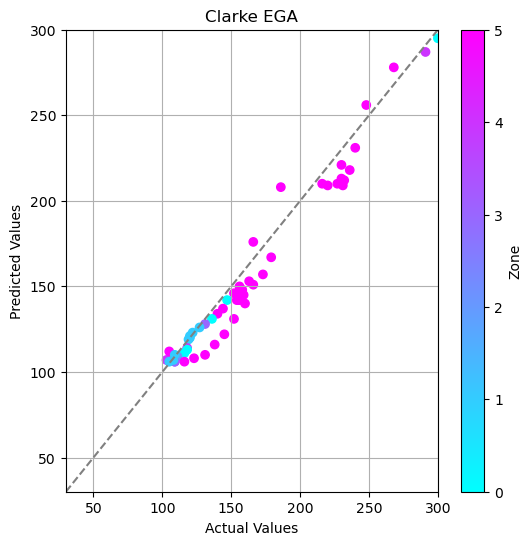

In [31]:
import matplotlib.pyplot as plt

# 生成示例数据，实际观测值和预测值
actual_values = true_value
predicted_values = pred_value

# 计算Clarke EGA图中的区域
def clarke_ega_region(actual, predicted):
    abs_diff = np.abs(predicted - actual)
    zones = np.zeros_like(abs_diff, dtype=int)
    zones[(abs_diff <= 1)] = 1
    zones[(abs_diff <= 2) & (abs_diff >1)] = 2
    zones[(abs_diff <= 3) & (abs_diff > 2)] = 3
    zones[(abs_diff <= 4) & (abs_diff > 3)] = 4
    zones[(abs_diff > 5)] = 5
    return zones

zones = clarke_ega_region(actual_values, predicted_values)

# 绘制Clarke EGA图
plt.figure(figsize=(6, 6))
plt.scatter(actual_values, predicted_values, c=zones, cmap='cool', marker='o')
plt.plot([30,300], [30,300], color='gray', linestyle='--')
plt.xlim(30,300)
plt.ylim(30,300)
plt.title("Clarke EGA")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

plt.grid()
plt.colorbar(label="Zone")

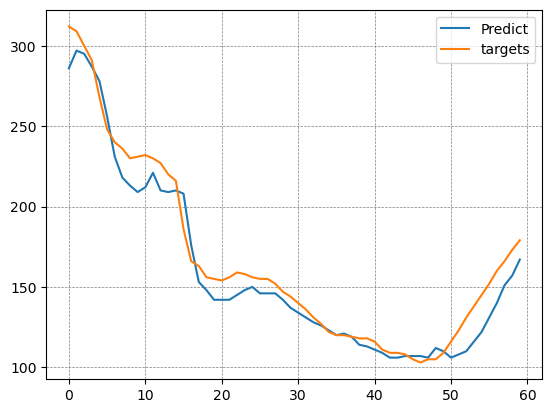

In [32]:
# 绘制predict 和 targets 的对比图
import matplotlib.pyplot as plt

plt.plot(pred_value, label="Predict")    # 预测值
plt.plot(true_value, label="targets")    # 真实值
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [33]:
# 想使用训练集的最后一个窗口预测训练集的下一个数据，再将窗口第一个数据弹出，将预测值插入窗口末尾组成一个新窗口。但是模型的输出是单个血糖值
# 缺了一些时间特征。要想实现真正的预测（有误差积累的预测）必须改变模型，使模型输出一个样本。
result = []
x = testX[0,:,:].unsqueeze(0).to(device)
print(x.shape)
for i in range(50):
    
    y = model(x)
    
    x = torch.cat((x[:,1:,:], y.unsqueeze(1)), dim=1)

    result.append(y.cpu().detach().numpy())

torch.Size([1, 24, 7])


(50, 1, 7)


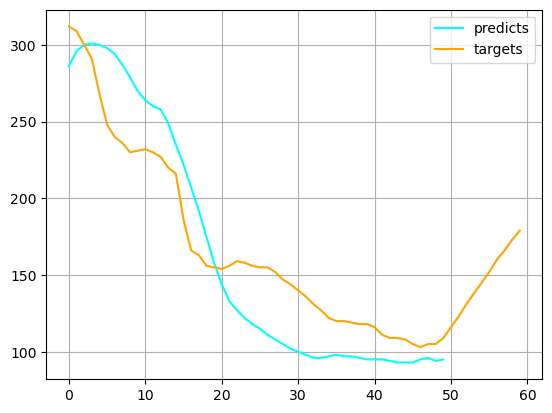

In [34]:
result = np.array(result)
print(result.shape)
pred_values = scaler3.inverse_transform(result.reshape(-1,7))[:,-1].round()

true_values = testY.cpu().numpy()
true_values = scaler3.inverse_transform(true_values)[:,-1].round()

plt.plot(pred_values,color='cyan',label='predicts')
plt.plot(true_values,color='orange', label='targets')
plt.legend()
plt.grid()
plt.show()

In [96]:
len(range(344,len(testY)))

50